## Preprocess

In [1]:
import jsonlines
import pandas
import json
# Load the data from the JSON line file
with open('../data/kotlin-practice.jsonl', 'r') as f:
    dataframe = pandas.DataFrame([json.loads(line) for line in f])

In [2]:
dataframe.head()

,id,repo,revision,path,modified,prefix,suffix,archive
0,0d19dd,LinkSheet/LinkSheet,11d221b76b2fe40c589c4e44d9706b0c9fd11cd0,app/src/main/java/fe/linksheet/module/resolver...,[app/src/main/java/fe/linksheet/module/resolve...,package fe.linksheet.module.resolver\n\nimport...,"\n return map.mapNotNull { (_, activity...",LinkSheet__LinkSheet-11d221b76b2fe40c589c4e44d...
1,046696,LinkSheet/LinkSheet,1af0ed9ad6d3b790589b537cb32284c8c2d64ff6,app/src/main/java/fe/linksheet/composable/comp...,[app/src/main/java/fe/linksheet/activity/Botto...,package fe.linksheet.composable.component.list...,"checked = preference,\n onCheck...",LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb...
2,a508ff,LinkSheet/LinkSheet,25ef07550aea5ddff12f5af7c1b94f1f5ccd3df3,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/fe/linksheet/activity/Botto...,package fe.linksheet.composable.settings.botto...,}\n }\n }\n},LinkSheet__LinkSheet-25ef07550aea5ddff12f5af7c...
3,c2fddc,LinkSheet/LinkSheet,312d245779c6e4f3066887a1d83ba33aa8b9db60,app/src/main/java/fe/linksheet/composable/sett...,[app/src/main/java/com/tasomaniac/openwith/res...,package fe.linksheet.composable.settings\n\nim...,\n fun getUsageStatsAllowed(context: Contex...,LinkSheet__LinkSheet-312d245779c6e4f3066887a1d...
4,85e922,LinkSheet/LinkSheet,363391105db1b6d378189e8687f162a865b74a44,app/src/main/java/fe/linksheet/InterconnectSer...,[app/src/main/java/fe/linksheet/InterconnectSe...,package fe.linksheet\n\nimport android.app.Ser...,}\n }\n }\n\n overrid...,LinkSheet__LinkSheet-363391105db1b6d378189e868...


In [3]:
import os
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
DATA_ROOT = "../data/repositories-kotlin-practice/"



def extract_original_code_from_row(row: pandas.Series) -> str:
    """
    Extract the original code from the file path.
    """
    repo_path = os.path.join(DATA_ROOT, "-".join([row["repo"].replace("/", "__"), row['revision']]))
    file_path = repo_path + "/" + row['path']
    with open(file_path, 'r') as file:
        content = file.read()
    return content

dataframe['original_code'] = dataframe.apply(extract_original_code_from_row, axis=1)
dataframe['incomplete_code'] = dataframe.apply(lambda row: SEPARATOR_COMMENT.join([row['prefix'], row['suffix']]), axis=1)


In [4]:
import diff_match_patch

def extract_diff_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the diff from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.diff_lineMode(original_code, incomplete_code, deadline=None)
    # Convert the diffs to a single diff string
    diffs = "\n".join([diff[1] for diff in diffs if diff[0] != 0])
    return diffs

def extract_patch_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the patch from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.patch_make(original_code, incomplete_code)
    # Convert the patches to a single patch string
    patches = dmp.patch_toText(diffs)
    return patches




In [5]:
for index, row in dataframe.iterrows():
    output_root = "../samples-practice/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    dir_name = os.path.join(output_root, repo_revision)
    os.makedirs(dir_name, exist_ok=True)
    original_file_path = os.path.join(dir_name, "original.kt")
    incomplete_file_path = os.path.join(dir_name, "incomplete.kt")
    diff_file_path = os.path.join(dir_name, "diff.diff")
    patch_file_path = os.path.join(dir_name, "patch.patch")
    
    
    with open(original_file_path, 'w') as original_file:
        original_file.write(row['original_code'])
    with open(incomplete_file_path, 'w') as incomplete_file:
        incomplete_file.write(row['incomplete_code'])
    with open(diff_file_path, 'w') as diff_file:
        diff_file.write(extract_diff_from_original_code_and_incomplete_code(row))
    with open(patch_file_path, 'w') as patch_file:
        patch_file.write(extract_patch_from_original_code_and_incomplete_code(row))
    
    dataframe.at[index, 'diff'] = extract_diff_from_original_code_and_incomplete_code(row)
    dataframe.at[index, 'patch'] = extract_patch_from_original_code_and_incomplete_code(row)

        


In [6]:

def extract_diff_prefix_and_suffix(row: pandas.Series) -> tuple[str, str]:
    """
    Extract the prefix and suffix from the diff.
    """
    diff = row['diff']
    splitted = diff.split(SEPARATOR_COMMENT)
    if len(splitted) < 2:
        return splitted[0], ""
    return splitted[0], splitted[1]

In [7]:
extract_diff_prefix_and_suffix(dataframe.iloc[0])

('\n\n        return deduplicate(filtered)\n    }\n\n    private fun deduplicate(filtered: List<ResolveInfo>): List<ResolveInfo> {\n        val map = mutableMapOf<String, ActivityAlias>()\n        f',
 '\n        return map.mapNotNull { (_, activity) -> activity.get() }\n\n\n')

In [8]:
for index, row in dataframe.iterrows():
    output_root = "../samples-practice/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    diff_prefix, diff_suffix = extract_diff_prefix_and_suffix(row)
    dataframe.at[index, 'diff_prefix'] = diff_prefix
    dataframe.at[index, 'diff_suffix'] = diff_suffix
    prefix, suffix = row['prefix'], row['suffix']
    with open(os.path.join(output_root, repo_revision, "diff_prefix.kt"), 'w') as f:
        f.write(diff_prefix)
    with open(os.path.join(output_root, repo_revision, "diff_suffix.kt"), 'w') as f:
        f.write(diff_suffix)
    with open(os.path.join(output_root, repo_revision, "prefix.kt"), 'w') as f:
        f.write(prefix)
    with open(os.path.join(output_root, repo_revision, "suffix.kt"), 'w') as f:
        f.write(suffix)

In [9]:
dataframe['diff_prefix'] 

0     \n\n        return deduplicate(filtered)\n    ...
1     \n\n@Composable\nfun PreferenceDividedSwitchLi...
2     \n\n            item(key = "enable_request_pri...
3         fun onUsageStatsSorting(it: Boolean) {\n  ...
4     \n\n            override fun selectDomainsWith...
5     }\n    fun getDomainVerificationAppInfos(): Fl...
6     \n\n\n\n/**\n * Yes, I absolutely stole this f...
7     \n\n    fun followRedirects(\n        uri: Uri...
8             enabled = enabled,\n        rightConte...
9     }\n    companion object {\n        internal fu...
10        fun <T> writeInt(preference: Preference<T>...
11    /**\n * The default light scrim, as defined by...
12    \n\n            item(key = "mode", contentType...
13                item(key = "privacy") {\n         ...
14    \ntypealias Transform<T, R, S> = suspend (T, P...
15    }\n    private val preferencesLoggable = listO...
16    //    Log.d("Preview", "$unfurlResult")\n    u...
17    \ninline fun <T> ViewModel.ioAsync(\n    l

## Syntax tree analysis

In [10]:
# Let's create a simple example to demonstrate the tree-sitter query matching
import tree_sitter
from tree_sitter_languages import get_language
# Sample Kotlin code
kotlin_code = """
class Person(val name: String) {
    var age: Int = 0
    
    fun getInfo(): String {
        return "Name: $name, Age: $age"
    }
    
    // This is a comment
    @Override
    fun toString() = "Person(name=$name)"
}
"""

# Create a parser
parser = tree_sitter.Parser()
parser.set_language(get_language("kotlin"))

# Parse the code
tree = parser.parse(bytes(kotlin_code, "utf8"))

# Print the syntax tree
print(tree.root_node.sexp())

(source_file (class_declaration name: (type_identifier) primary_constructor: (primary_constructor parameters: (class_parameter (simple_identifier) (user_type (type_identifier)))) body: (class_body (property_declaration variable: (variable_declaration (simple_identifier) (user_type (type_identifier))) expression: (integer_literal)) (function_declaration name: (simple_identifier) parameters: (function_value_parameters) return_type: (user_type (type_identifier)) body: (function_body (statements (jump_expression (string_literal (interpolated_identifier) (interpolated_identifier)))))) (line_comment) (function_declaration modifiers: (modifiers (annotation (user_type (type_identifier)))) name: (simple_identifier) parameters: (function_value_parameters) body: (function_body (string_literal (interpolated_identifier)))))))


In [11]:
def highlight_matches(code: str, query_string: str):
    """
    Highlight matches from a tree-sitter query in the given code
    """
    # Create a query
    language = get_language("kotlin")
    query = language.query(query_string)
    
    # Get matches
    tree = parser.parse(bytes(code, "utf8"))
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return
    
    
    # Print matches with their capture types
    for match in matches:
        print(match)

In [12]:
# Let's try some specific queries

# Find all function declarations
function_query = """
(function_declaration 
    . (simple_identifier) @function_name) @function
"""
print("Function declarations:")
highlight_matches(kotlin_code, function_query)

# Find class declarations
class_query = """(class_declaration
    (simple_identifier) @class_name) @class
"""

# Find class properties
property_query = """
(class_parameter
    (simple_identifier) @property)
(class_body
    (property_declaration
        (variable_declaration
            (simple_identifier) @property)))
"""
print("\nProperties:")
highlight_matches(kotlin_code, property_query)

Function declarations:
(<Node type=function_declaration, start_point=(4, 4), end_point=(6, 5)>, 'function')
(<Node type=simple_identifier, start_point=(4, 8), end_point=(4, 15)>, 'function_name')
(<Node type=function_declaration, start_point=(9, 4), end_point=(10, 41)>, 'function')

Properties:
(<Node type=simple_identifier, start_point=(1, 17), end_point=(1, 21)>, 'property')
(<Node type=simple_identifier, start_point=(2, 8), end_point=(2, 11)>, 'property')


In [13]:
# Function to analyze package and import relationships
def analyze_package_imports(code: str) -> tuple[str, list[str]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    
    # Parse the code
    language = get_language("kotlin")
    tree = parser.parse(bytes(code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node.text.decode("utf-8"))

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[str]) -> list[str]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.split('.')[0] == root_package
    ]
    
    return same_repo_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports:")
for imp in imports:
    print(f"  {imp}")

same_repo_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp}")

Package: fe.linksheet.module.resolver

Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat


## Token-level Analysis

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("JetBrains/Mellum-4b-sft-kotlin")


/Users/minhna1112/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
print(tokenizer.encode(kotlin_code))

[225, 925, 15970, 34, 841, 517, 52, 1269, 35, 339, 225, 247, 247, 247, 924, 5522, 52, 1410, 306, 369, 225, 225, 247, 247, 247, 4131, 779, 1243, 3161, 1269, 339, 225, 247, 247, 247, 247, 247, 247, 247, 545, 327, 574, 52, 427, 380, 38, 14369, 52, 427, 471, 28, 225, 247, 247, 247, 367, 225, 225, 247, 247, 247, 521, 1461, 432, 283, 5617, 225, 247, 247, 247, 583, 2944, 225, 247, 247, 247, 4131, 17956, 403, 306, 327, 9512, 34, 380, 5050, 380, 2324, 225, 119, 225]


In [16]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_prefix_tokens'] = dataframe['prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens'] = dataframe['suffix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_diff_tokens'] = dataframe['diff'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_prefix_tokens_in_diff'] = dataframe['diff_prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens_in_diff'] = dataframe['diff_suffix'].apply(lambda x : len(code_to_tokens(x)))

In [17]:
dataframe[['num_prefix_tokens', 'num_suffix_tokens', 'num_diff_tokens']].head()

,num_prefix_tokens,num_suffix_tokens,num_diff_tokens
0,417,202,98
1,692,112,303
2,3432,28,135
3,2239,712,238
4,1239,332,50


Text(0, 0.5, 'Frequency')

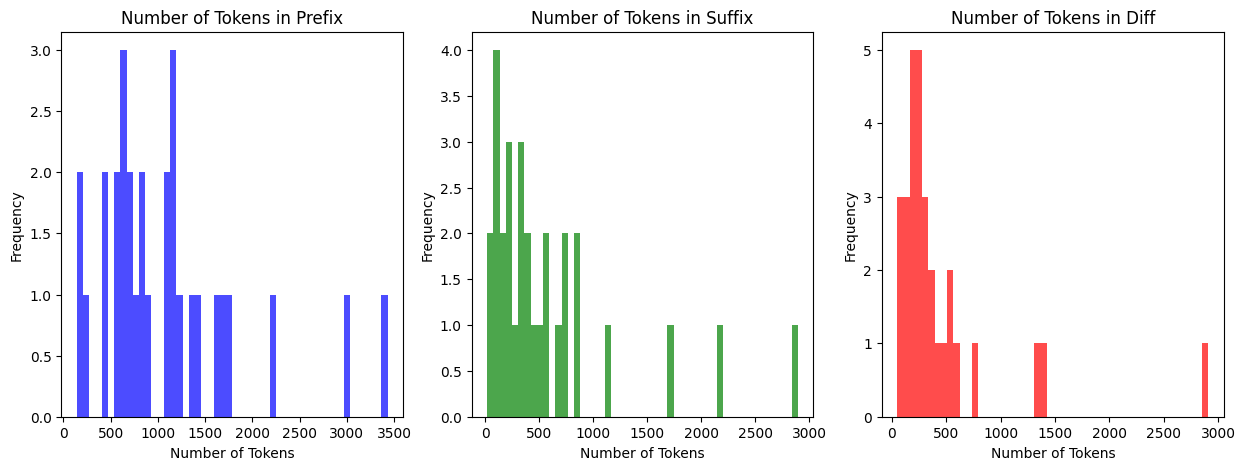

In [18]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

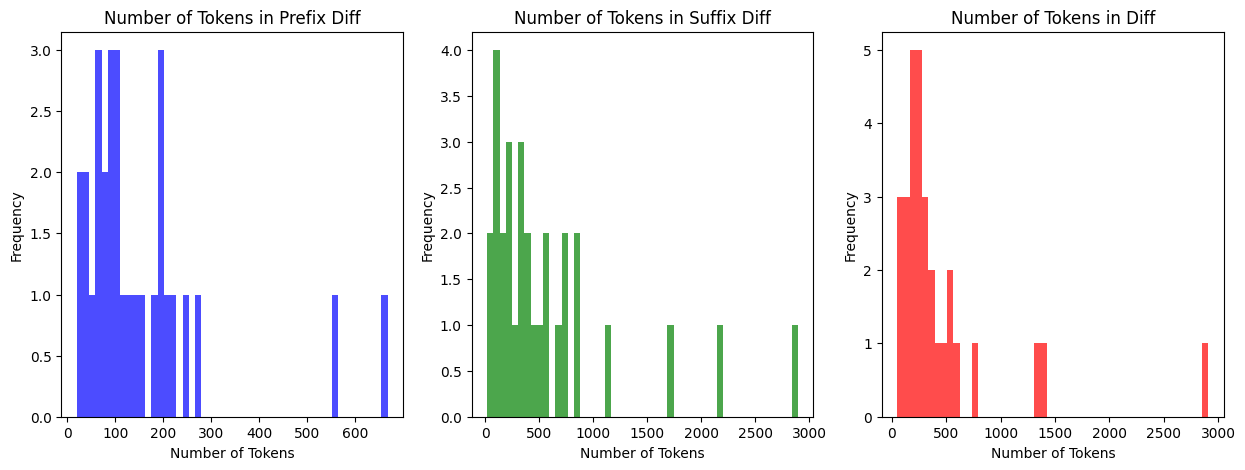

In [19]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_in_diff'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [20]:
def remove_comments_nodes(code: str)->str:
    """
    Remove comments from the code using tree-sitter
    """
    language = get_language("kotlin")
    parser = tree_sitter.Parser()
    parser.set_language(language)
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    # Parse the code
    tree = parser.parse(bytes(cleaned_code, "utf8"))

    # Query to find comment nodes
    query_str = """
    (line_comment) @comment
    (multiline_comment) @comment
    """
    
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    
    # Remove comment nodes from the code
    
    for match in matches:
        node = match[0]
        cleaned_code = cleaned_code[:node.start_byte] + cleaned_code[node.end_byte:]

    return cleaned_code

dataframe['prefix_without_comments'] = dataframe['prefix'].apply(
    remove_comments_nodes
)

dataframe['suffix_without_comments'] = dataframe['suffix'].apply(
    remove_comments_nodes
)
dataframe['diff_without_comments'] = dataframe['diff'].apply(
    remove_comments_nodes
)



Text(0.5, 1.0, 'Number of Tokens in Diff')

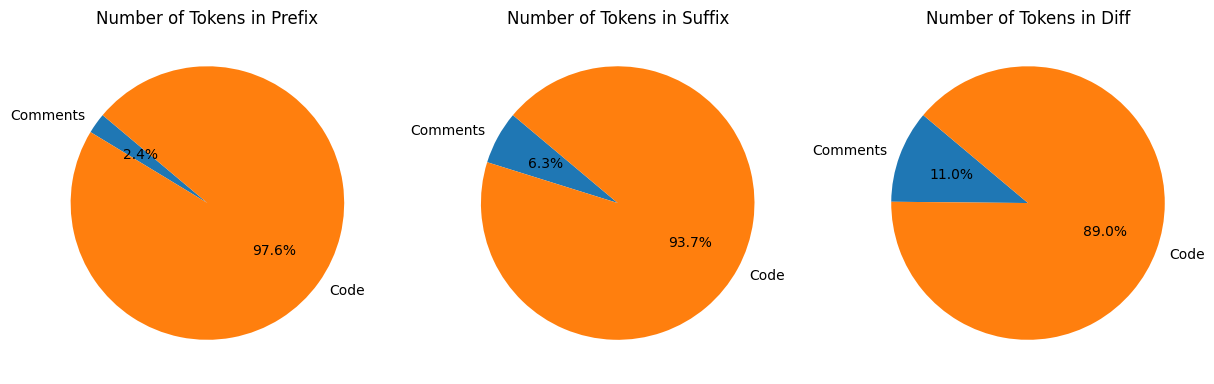

In [21]:
dataframe["num_prefix_tokens_without_comments"] = dataframe['prefix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_suffix_tokens_without_comments"] = dataframe['suffix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_diff_tokens_without_comments"] = dataframe['diff_without_comments'].apply(lambda x : len(code_to_tokens(x)))

# plot 3 pie charts of the number of tokens  between code and comments (original - code) in prefix, suffix, and diff

import matplotlib.pyplot as plt

labels = ['Comments', 'Code']
prefix_sizes = [
    dataframe['num_prefix_tokens'].sum() - dataframe['num_prefix_tokens_without_comments'].sum(),
    dataframe['num_prefix_tokens_without_comments'].sum()
]
suffix_sizes = [
    dataframe['num_suffix_tokens'].sum() - dataframe['num_suffix_tokens_without_comments'].sum(),
    dataframe['num_suffix_tokens_without_comments'].sum()
]
diff_sizes = [
    dataframe['num_diff_tokens'].sum() - dataframe['num_diff_tokens_without_comments'].sum(),
    dataframe['num_diff_tokens_without_comments'].sum()
]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pie(prefix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Prefix')
plt.subplot(1, 3, 2)
plt.pie(suffix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Suffix')
plt.subplot(1, 3, 3)
plt.pie(diff_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Diff')


Text(0, 0.5, 'Frequency')

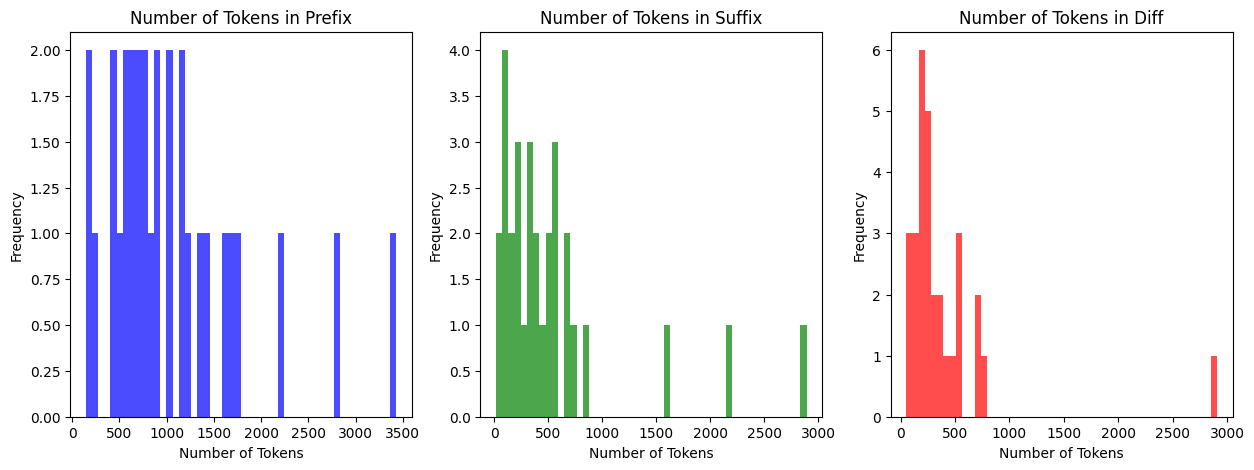

In [22]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff (after removing comments)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_without_comments'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens_without_comments'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens_without_comments'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

### Import Analysis



In [23]:
# Function to analyze package and import relationships
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
def analyze_package_imports(code: str) -> tuple[str, list[Node]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    parser = get_parser("kotlin")
    # Parse the code
    language = get_language("kotlin")
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(cleaned_code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node)

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[Node]) -> list[Node]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] == root_package
    ]
    external_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] != root_package
    ]

    return same_repo_imports, external_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")

same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")

def remove_import_nodes(code: str, import_nodes: list[Node]) -> str:
    """
    Remove import statements from the code using tree-sitter
    """
    for node in import_nodes:
        code = code[:node.start_byte] + code[node.end_byte:]

    return code



for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")

print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}")


# A function to at the same time identify pakage name, extract in-repository and external imports, and remove import nodes from prefix
def analyze_and_clean_imports(code: str) -> tuple[str, list[str], list[str], str]:
    """
    Analyze the code to extract package name, in-repository imports, external imports,
    and return the cleaned code without import statements.
    """
    package_name, imports = analyze_package_imports(code)
    same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
    cleaned_code = remove_import_nodes(code, same_repo_imports)
    return package_name, same_repo_imports, external_imports, cleaned_code

package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")
print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}") 
print("\nCleaned Code:")


Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri

Cleaned Code:


In [24]:
for index, row in dataframe.iterrows():
    package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(row.prefix)
    dataframe.at[index, 'package_name'] = package_name
    dataframe.at[index, 'same_repo_imports'] = [imp.text.decode('utf-8') for imp in same_repo_imports]
    dataframe.at[index, 'external_imports'] = [imp.text.decode('utf-8') for imp in external_imports]
    dataframe.at[index, 'prefix_without_imports'] = cleaned_code

ValueError: Must have equal len keys and value when setting with an iterable

In [25]:
# pie charts of the number of imports in same repository and external imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(len).sum().astype(int)
external_counts = dataframe['external_imports'].apply(len).sum().astype(int)
sizes = [same_repo_counts, external_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

KeyError: 'external_imports'

In [26]:
# pie charts of the number of tokens of imports in same repository and external imports, and the prefix without imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports', 'Prefix Without Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
external_counts = dataframe['external_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
prefix_counts = dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
sizes = [same_repo_counts, external_counts, prefix_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

KeyError: 'external_imports'

KeyError: 'prefix_without_imports'

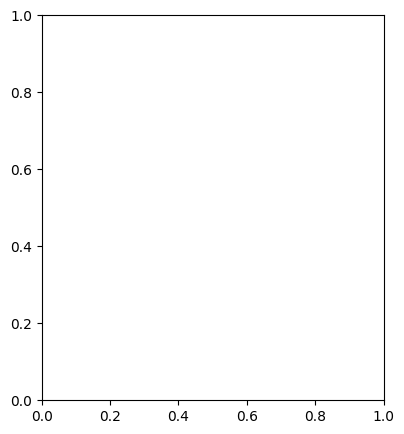

In [27]:
# 3 histograms of the number of tokens in prefix (after removing imports), suffix, and diff 
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))), bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

### Localize Completion Point

In [28]:
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
# using tree-sitter to find multi-line comment nodes in the diff
import re
import pandas
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
def detect_completion_point(row) -> tuple[int, int]:
    """
    Detect the completion point by taking the end point of the prefix.
    """
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(row["prefix"], "utf8"))
    # Find the end point of the prefix
    if not tree.root_node.children:
        return tree.root_node.end_point
    
    # The completion point is the end point of the last child node
    last_child = tree.root_node.children[-1]
    return last_child.end_point 

def detect_completion_point_in_diff(row: pandas.Series) -> tuple[int, int]:
    """
    Detect the completion point in the diff by taking the end point of the prefix.
    """
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(row["diff_prefix"], "utf8"))

    # Find the end point of the prefix
    if not tree.root_node.children:
        return tree.root_node.end_point
    
    # The completion point is the end point of the last child node
    last_child = tree.root_node.children[-1]
    return last_child.end_point 

def localize_outer_symbol_from_completion_point(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("kotlin")
    incomplete_code = row["incomplete_code"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../kotlin_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("kotlin").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]
    
    completion_point = detect_completion_point(row)
    
    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            # print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neighbor (sibiling of the closest parent) nodes
        
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)


def localize_outer_symbol_from_completion_point_in_diff(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("kotlin")
    incomplete_code = row["diff"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../kotlin_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("kotlin").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]

    completion_point = detect_completion_point_in_diff(row)

    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            # print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neighbor (sibiling of the closest parent) nodes
        
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)

In [29]:
dataframe['completion_point'] = dataframe.apply(detect_completion_point, axis=1)
dataframe['completion_point_in_diff'] = dataframe.apply(detect_completion_point_in_diff, axis=1)

In [30]:
outer_symbol = localize_outer_symbol_from_completion_point(dataframe.iloc[1])

In [31]:
outer_symbol_diff = localize_outer_symbol_from_completion_point_in_diff(dataframe.iloc[1])

In [32]:
outer_symbol[0].text.decode("utf-8"), outer_symbol[0].start_point, outer_symbol[0].end_point, outer_symbol[1]

('DividedSwitchListItem(\n        enabled = enabled,\n        shape         checked = preference,\n        onCheckedChange = { statePreference.update(it) },\n        onContentClick = onContentClick,\n        overlineContent = overlineContent,\n        headlineContent = headlineContent,\n        supportingContent = supportingContent,\n        otherContent = otherContent\n    )',
 (58, 4),
 (67, 5),
 'function.declaration')

In [33]:
outer_symbol_diff[0].text.decode("utf-8"), outer_symbol_diff[0].start_point, outer_symbol_diff[0].end_point, outer_symbol_diff[1]

('DividedSwitchListItem(\n        enabled = enabled,\n        shape         checked = preference,\n        onCheckedChange = { statePreference.update(it) },\n        onContentClick = onContentClick,\n        overlineContent = overlineContent,\n        headlineContent = headlineContent,\n        supportingContent = supportingContent,\n        otherContent = otherContent\n    )',
 (16, 4),
 (25, 5),
 'function.declaration')

In [34]:
for index, row in dataframe.iterrows():
   outer_symbol = localize_outer_symbol_from_completion_point(row)
   outer_symbol_diff = localize_outer_symbol_from_completion_point_in_diff(row)

   if not outer_symbol_diff[0]:
        print(f"No outer symbol in diff found for row {index}")
        if not outer_symbol[0] :
            print(f"No outer symbol found for row {index}")
            continue
        else:
            dataframe.at[index, 'container_symbol'] = outer_symbol[0].text.decode("utf-8") if outer_symbol else None
            dataframe.at[index, 'container_symbol_type'] = outer_symbol[0].type if outer_symbol else None
   else:
        dataframe.at[index, 'container_symbol_in_diff'] = outer_symbol_diff[0].text.decode("utf-8") if outer_symbol_diff else None
        dataframe.at[index, 'container_symbol_type_in_diff'] = outer_symbol_diff[0].type if outer_symbol_diff else None


No outer symbol in diff found for row 0
No outer symbol in diff found for row 3
No outer symbol in diff found for row 4
No outer symbol in diff found for row 8
No outer symbol in diff found for row 11
No outer symbol found for row 11
No outer symbol in diff found for row 16
No outer symbol in diff found for row 17
No outer symbol found for row 17
No outer symbol in diff found for row 19
No outer symbol in diff found for row 24
No outer symbol in diff found for row 29
No outer symbol found for row 29


In [34]:
for index, row in dataframe.iterrows():
    if not row['container_symbol_in_diff']:
        print(f"No outer symbol found in diff for row {index}")
        if not row['container_symbol']:
            print(f"No outer symbol  found for row {index}")
            continue
        with open(f"../samples-practice/{row['repo'].replace('/', '__')}-{row['revision']}/container_symbol.kt", 'w') as f:
            f.write(row['container_symbol'])
    else:
        with open(f"../samples-practice/{row['repo'].replace('/', '__')}-{row['revision']}/container_symbol_in_diff.kt", 'w') as f:
            f.write(str(row['container_symbol_in_diff']))

In [35]:
dataframe['container_symbol_type'].value_counts()

container_symbol_type
function_declaration    3
call_expression         2
object_declaration      1
class_declaration       1
Name: count, dtype: int64

<Axes: title={'center': 'Container Symbol Type Distribution'}, ylabel='count'>

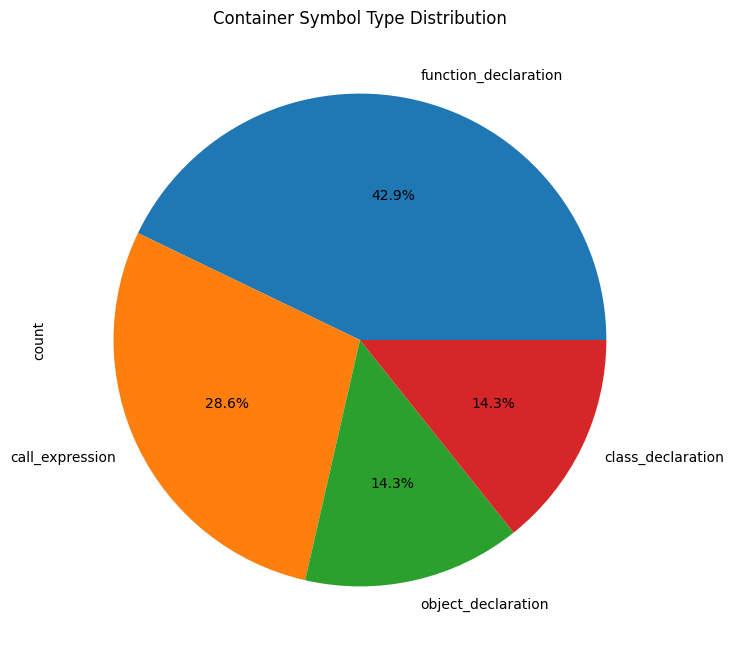

In [36]:

dataframe['container_symbol_type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Container Symbol Type Distribution')

In [37]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_tokens_container_symbol'] = dataframe['container_symbol'].apply(lambda x: len(code_to_tokens(x)))

AttributeError: 'float' object has no attribute 'replace'

In [35]:
dataframe['num_tokens_container_symbol'].hist(bins=50, color='blue', alpha=0.7)

KeyError: 'num_tokens_container_symbol'

In [36]:
dataframe['num_diff_tokens'].median()

np.float64(257.0)

In [37]:
dataframe.to_csv("../data/kotlin_practice_analyzed.csv", index=False)

## Diff Analysis

### Answer analysis


In [38]:
import jsonlines

answers_batch = []

with jsonlines.open('../data/answers-kotlin-practice.jsonl', 'r') as reader:
    for obj in reader:
        answers_batch.append(obj['middle'])


In [39]:
tokenized_answers = [code_to_tokens(answer) for answer in answers_batch]

In [40]:
dataframe['num_token_answers'] = [len(tokens) for tokens in tokenized_answers]

In [41]:
dataframe['num_token_answers'].max(
)

np.int64(279)

### Zoekt


In [42]:
import requests
import json

url = "http://localhost:6070/api/search"

payload = json.dumps({
  "Q": "deduplicate filtered deduplicate filtered List ResolveInfo List ResolveInfo map mutableMapOf String ActivityAlias   r:LinkSheet__LinkSheet-",
  "Opts": {
    "NumContextLines": 5,
    "MaxResults": 10,
  }
})
headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)


{"Result":{"ContentBytesLoaded":18977,"IndexBytesLoaded":265444,"Crashes":0,"Duration":46485583,"FileCount":6,"ShardFilesConsidered":0,"FilesConsidered":6,"FilesLoaded":6,"FilesSkipped":0,"ShardsScanned":16,"ShardsSkipped":0,"ShardsSkippedFilter":14,"MatchCount":122,"NgramMatches":539,"NgramLookups":17776,"Wait":442750,"MatchTreeConstruction":231470669,"MatchTreeSearch":26779873,"RegexpsConsidered":0,"FlushReason":0,"Files":[{"FileName":"app/src/main/java/fe/linksheet/module/resolver/PackageHandler.kt","Repository":"LinkSheet__LinkSheet-a0cd33b594891117252e4f50d94f37f673596e43","Language":"Kotlin","LineMatches":[{"Line":"ICAgIGNsYXNzIEFjdGl2aXR5QWxpYXMoCg==","LineStart":668,"LineEnd":693,"LineNumber":23,"Before":"ICAgICAgICBQYWNrYWdlTWFuYWdlci5HRVRfUkVTT0xWRURfRklMVEVSLAogICAgICAgIFBhY2thZ2VNYW5hZ2VyLk1BVENIX0RJU0FCTEVEX0NPTVBPTkVOVFMsCiAgICAgICAgUGFja2FnZU1hbmFnZXIuR0VUX01FVEFfREFUQQogICAgKQoK","After":"ICAgICAgICB2YXIgYWN0aXZpdHk6IFJlc29sdmVJbmZvPyA9IG51bGwsCiAgICAgICAgcHJpdmF0ZSB2YW

In [43]:

searched = response.json()

In [44]:
searched_files = searched['Result']['Files']

In [45]:
searched_files

[{'FileName': 'app/src/main/java/fe/linksheet/module/resolver/PackageHandler.kt',
  'Repository': 'LinkSheet__LinkSheet-a0cd33b594891117252e4f50d94f37f673596e43',
  'Language': 'Kotlin',
  'LineMatches': [{'Line': 'ICAgIGNsYXNzIEFjdGl2aXR5QWxpYXMoCg==',
    'LineStart': 668,
    'LineEnd': 693,
    'LineNumber': 23,
    'Before': 'ICAgICAgICBQYWNrYWdlTWFuYWdlci5HRVRfUkVTT0xWRURfRklMVEVSLAogICAgICAgIFBhY2thZ2VNYW5hZ2VyLk1BVENIX0RJU0FCTEVEX0NPTVBPTkVOVFMsCiAgICAgICAgUGFja2FnZU1hbmFnZXIuR0VUX01FVEFfREFUQQogICAgKQoK',
    'After': 'ICAgICAgICB2YXIgYWN0aXZpdHk6IFJlc29sdmVJbmZvPyA9IG51bGwsCiAgICAgICAgcHJpdmF0ZSB2YWwgYWxpYXNlczogTXV0YWJsZUxpc3Q8UmVzb2x2ZUluZm8+ID0gbXV0YWJsZUxpc3RPZigpLAogICAgKSB7CiAgICAgICAgZnVuIGFkZChhbGlhczogUmVzb2x2ZUluZm8pIHsKICAgICAgICAgICAgYWxpYXNlcy5hZGQoYWxpYXMpCg==',
    'FileName': False,
    'Score': 8500.933333333332,
    'DebugScore': '',
    'LineFragments': [{'LineOffset': 10,
      'Offset': 678,
      'MatchLength': 13,
      'SymbolInfo': None}]},
   {'Line'

In [46]:
import base64

def decode_line(line: str) -> str:
    """
    Decode a base64 encoded line.
    """
    return base64.b64decode(line).decode('utf-8')

matches = searched_files[0]['LineMatches']
# matches.sort(key=lambda x: x['LineNumber'])
code_snippets = ["".join([decode_line(match['Before']), decode_line(match['Line']), decode_line(match['After'])]) for match in matches]

In [47]:
code_snippets

['        PackageManager.GET_RESOLVED_FILTER,\n        PackageManager.MATCH_DISABLED_COMPONENTS,\n        PackageManager.GET_META_DATA\n    )\n\n    class ActivityAlias(\n        var activity: ResolveInfo? = null,\n        private val aliases: MutableList<ResolveInfo> = mutableListOf(),\n    ) {\n        fun add(alias: ResolveInfo) {\n            aliases.add(alias)\n',
 '        }\n\n        return deduplicate(filtered)\n    }\n\n    private fun deduplicate(filtered: List<ResolveInfo>): List<ResolveInfo> {\n        val map = mutableMapOf<String, ActivityAlias>()\n        for (activity in filtered) {\n            val target = activity.activityInfo?.targetActivity\n            val key = "${activity.activityInfo.packageName}/${target ?: activity.activityInfo.name}"\n\n',
 '\n    fun findHandlers(context: Context, uri: Uri): List<ResolveInfo> {\n        val viewIntent = Intent(Intent.ACTION_VIEW, uri).addCategory(Intent.CATEGORY_BROWSABLE)\n        val activities = context.packageManager.q

In [48]:
code_snippets[0].split("\n")

['        PackageManager.GET_RESOLVED_FILTER,',
 '        PackageManager.MATCH_DISABLED_COMPONENTS,',
 '        PackageManager.GET_META_DATA',
 '    )',
 '',
 '    class ActivityAlias(',
 '        var activity: ResolveInfo? = null,',
 '        private val aliases: MutableList<ResolveInfo> = mutableListOf(),',
 '    ) {',
 '        fun add(alias: ResolveInfo) {',
 '            aliases.add(alias)',
 '']

In [49]:
sum([len(code_to_tokens(code_snippet)) for code_snippet in code_snippets])

2278

In [50]:
len(code_snippets)

15

In [51]:
decode_line(searched_files[0]['LineMatches'][0]['After'])

'        var activity: ResolveInfo? = null,\n        private val aliases: MutableList<ResolveInfo> = mutableListOf(),\n    ) {\n        fun add(alias: ResolveInfo) {\n            aliases.add(alias)\n'

In [139]:
from typing import List



def process_navigation_expression(s: str, case_sensitive: bool) -> str:
    s =  "".join(c if c.isalnum() else " " for c in s)
    s = ".".join(s.strip().replace("\n", " ").replace("  ", " ").split())    
    s = s.lower() if not case_sensitive else s
    return s

def process_navigation_expressions(navigation_expressions: List[str], case_sensitive: bool) -> List[str]:
    navigation_expressions = list(set(navigation_expressions))  # Remove duplicates
    return [process_navigation_expression(expr, case_sensitive) for expr in navigation_expressions]

def filter_and_rank_identifiers(identifiers: List[str], maximum_terms: int) -> List[str]:
     # rank identifiers by their frequency in the code snippet
    identifier_counts = {identifier: identifiers.count(identifier) for identifier in identifiers}
    identifiers = sorted(identifiers, key=lambda x: identifier_counts[x], reverse=True)
    identifiers = list(set(identifiers))
    # Limit to maximum_terms
    return identifiers[:maximum_terms]

def construct_query_from_code_snippet(code_snippet: str, 
                                      repo_name: str, 
                                      use_temporal_context: bool,
                                      maximum_terms : int =10,
                                      keep_original_navigation: bool = True,
                                      case_sensitive: bool = False,
                                      use_or_logic: bool = False) -> str:
    """
    Construct a query from a code snippet.
    """
    # extract identifers and typed indentifiers
    language = get_language("kotlin")
    ts_query = """(simple_identifier) @identifier
            (type_identifier) @type_identifier
            (navigation_expression) @navigation_expression"""
    
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(code_snippet, "utf8"))
    # print(code_snippet)
    wild_identifiers = []
    navigation_expressions = []
    for match in language.query(ts_query).captures(tree.root_node):
        # Do something with the matches
        if match[1] == "identifier":
            wild_identifiers.append(match[0].text.decode('utf-8'))
        elif match[1] == "type_identifier":
            wild_identifiers.append(match[0].text.decode('utf-8'))
        elif match[1] == "navigation_expression":
            navigation_expressions.append(match[0].text.decode('utf-8'))

    extracted_identifiers_from_navigation_expression = []

    if navigation_expressions:
        processed_navigation_expressions = process_navigation_expressions(navigation_expressions, case_sensitive)
        print(f"Processed navigation expressions: {processed_navigation_expressions}")
        if keep_original_navigation:
            extracted_identifiers_from_navigation_expression =  processed_navigation_expressions
        else:
            for expr in processed_navigation_expressions:
                extracted_identifiers_from_navigation_expression += expr.split(".") 

    if len(extracted_identifiers_from_navigation_expression) > maximum_terms:
        print("Number of extracted identifiers from navigation expression exceeds maximum terms, filtering and ranking them.")
        extracted_identifiers_from_navigation_expression = filter_and_rank_identifiers(extracted_identifiers_from_navigation_expression, maximum_terms)
        
    if len(extracted_identifiers_from_navigation_expression) == 0:
        # Resort to wild identifiers if no navigation expressions are found
        print(f"No navigation expressions found ({len(extracted_identifiers_from_navigation_expression)}), using wild identifiers.")
        if len(wild_identifiers) > maximum_terms:
            wild_identifiers = filter_and_rank_identifiers(wild_identifiers, maximum_terms)

    if use_temporal_context:
        repo_name = repo_name.split("-")[0]  # Use the first part of the repo name

    if extracted_identifiers_from_navigation_expression:
        query =  " ".join(extracted_identifiers_from_navigation_expression)
    else:
        query = " ".join(wild_identifiers)
    if use_or_logic:
        query = " or ".join(query.split())
    return query.replace("\n", " ").replace("  ", " ").strip() + " " + f"r:{repo_name}"

In [142]:
for index, row in dataframe.iterrows():
    # Construct the query from the code snippet
    code_snippet  = row['diff_prefix']
    repo_name = row['repo'].replace("/", "__") + "-" + row['revision']
    use_temporal_context = True

    print(f"Constructing query for row {index} with repo {repo_name} and code snippet length {len(code_snippet)}")
    query = construct_query_from_code_snippet(code_snippet, 
                                              repo_name, 
                                              use_temporal_context, 
                                              keep_original_navigation=True,
                                              case_sensitive=True,
                                              use_or_logic=False,
                                              maximum_terms=3)
    dataframe.at[index, 'query'] = query
    with open(f"../samples-practice/{repo_name}/query.txt", 'w') as f:
        f.write(query)

Constructing query for row 0 with repo LinkSheet__LinkSheet-11d221b76b2fe40c589c4e44d9706b0c9fd11cd0 and code snippet length 189
No navigation expressions found (0), using wild identifiers.
Constructing query for row 1 with repo LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb32284c8c2d64ff6 and code snippet length 642
Processed navigation expressions: ['CommonDefaults.EmptyPadding', 'CustomShapeDefaults.SingleShape', 'EnabledContent.all', 'statePreference.collectAsStateWithLifecycle']
Number of extracted identifiers from navigation expression exceeds maximum terms, filtering and ranking them.
Constructing query for row 2 with repo LinkSheet__LinkSheet-25ef07550aea5ddff12f5af7c1b94f1f5ccd3df3 and code snippet length 239
Processed navigation expressions: ['viewModel.enableRequestPrivateBrowsingButton']
Constructing query for row 3 with repo LinkSheet__LinkSheet-312d245779c6e4f3066887a1d83ba33aa8b9db60 and code snippet length 250
Processed navigation expressions: ['this.preferenceRepositor

In [150]:
ZOEKT_URL = "http://localhost:6070/api/search"
NUM_CONTEXT_LINES = 10
MAX_RESULTS = 10
def zoekt_search_request(query: str, 
                        num_context_lines: int = NUM_CONTEXT_LINES, 
                        max_results: int = MAX_RESULTS) -> dict:
    """
    Make a request to the zoekt search API.
    """
    url = ZOEKT_URL
    payload = json.dumps({
      "Q": query,
      "Opts": {
        "NumContextLines": num_context_lines,
        "MaxResults": max_results,
      }
    })
    headers = {
      'Content-Type': 'application/json'
    }
    
    response = requests.request("POST", url, headers=headers, data=payload)
    
    return response.json()


def merge_overlapping_ranges(snippets):
    """
    Merge overlapping code snippets and return consolidated line ranges.
    
    Args:
        snippets: List of snippet dicts with 'LineStart' and 'LineEnd' fields
        
    Returns:
        List of merged ranges as (start_line, end_line) tuples
    """
    if not snippets:
        return []
    
    # Extract and sort ranges by start line
    ranges = [(s['start_line'], s['end_line']) for s in snippets]
    ranges.sort(key=lambda x: x[0])
    
    merged_ranges = []
    current_start, current_end = ranges[0]
    
    for start, end in ranges[1:]:
        # Check if current range overlaps or touches the next range
        if start <= current_end + 1:  # +1 to merge adjacent ranges too
            # Extend current range
            current_end = max(current_end, end)
        else:
            # No overlap, save current range and start new one
            merged_ranges.append((current_start, current_end))
            current_start, current_end = start, end
    
    # Don't forget the last range
    merged_ranges.append((current_start, current_end))
    
    return merged_ranges


def get_merged_snippets_from_file(snippets, file_lines):
    """
    Extract merged code snippets from original file.
    
    Args:
        snippets: List of snippet dicts
        file_lines: List of strings (lines from original file)
        
    Returns:
        List of merged code snippets as strings
    """
    merged_ranges = merge_overlapping_ranges(snippets)
    merged_snippets = []
    
    for start_line, end_line in merged_ranges:
        # Convert to 0-based indexing for Python list slicing
        snippet_lines = file_lines[start_line - 1:end_line]
        merged_snippets.append('\n'.join(snippet_lines))
    
    return merged_snippets

def postprocess_search_results(
    search_results: dict, 
    top_k_file: int = 1,
    top_k_matches: int = 5, 
    total_max_context_tokens: int = 4096,
    merge_overlapping: bool = True,
) -> dict:
    """
    Postprocess the search results to extract relevant information.
    """
    if 'Result' not in search_results or 'Files' not in search_results['Result'] or search_results['Result']['FileCount'] == 0:
        print("No search results found or no files in the results.")
        return {"context": ""}
    
    max_context_tokens = total_max_context_tokens // top_k_file
    remaining_context_tokens = total_max_context_tokens
    files = search_results['Result']['Files']
    processed_contexts = []

    def extract_context(file_name, content):
        return "<|file_sep|>" + file_name + "\n" + content

    def get_line_infos(line_matches):
        return [
            {
                'start_line': match['LineNumber'] - NUM_CONTEXT_LINES - 1,
                'end_line': match['LineNumber'] + NUM_CONTEXT_LINES,
            }
            for match in line_matches[:top_k_matches]
        ]

    for file in files[:top_k_file]:
        file_path = os.path.join(DATA_ROOT, file['Repository'], file['FileName'])
        with open(file_path, 'r') as f:
            file_content = f.read()
        context_str = extract_context(file['FileName'], file_content)
        file_num_tokens = len(code_to_tokens(context_str))
        
        if file_num_tokens <= max_context_tokens and remaining_context_tokens - file_num_tokens >= 0:
            remaining_context_tokens -= file_num_tokens
            processed_contexts.append({"context": context_str})
            continue

        line_infos = get_line_infos(file['LineMatches'])
        lines = file_content.splitlines()

        if not merge_overlapping:
            for info in line_infos:
                snippet = "\n".join(lines[info['start_line']-1:info['end_line']-1])
                context_str = extract_context(file['FileName'], snippet)
                num_tokens = len(code_to_tokens(context_str))
                if num_tokens <= max_context_tokens and remaining_context_tokens - num_tokens >= 0:
                    remaining_context_tokens -= num_tokens
                    processed_contexts.append({"context": context_str})
        else:
            merged_snippets = get_merged_snippets_from_file(line_infos, lines)
            for snippet in merged_snippets:
                context_str = extract_context(file['FileName'], snippet)
                num_tokens = len(code_to_tokens(context_str))
                if num_tokens <= max_context_tokens and remaining_context_tokens - num_tokens >= 0:
                    remaining_context_tokens -= num_tokens
                    processed_contexts.append({"context": context_str})

    return {"context": "\n".join([c['context'] for c in processed_contexts])}


In [151]:
response= zoekt_search_request(
    "deduplicate filtered deduplicate filtered List ResolveInfo List ResolveInfo map mutableMapOf String ActivityAlias   r:LinkSheet__LinkSheet-",
    
)
context = postprocess_search_results(response)

In [136]:
context['context'].split("<|file_sep|>")[1].splitlines()

['app/src/main/java/fe/linksheet/module/resolver/PackageHandler.kt',
 'package fe.linksheet.module.resolver',
 '',
 'import android.content.Context',
 'import android.content.Intent',
 'import android.content.IntentFilter',
 'import android.content.IntentFilter.AuthorityEntry',
 'import android.content.pm.PackageManager',
 'import android.content.pm.ResolveInfo',
 'import android.content.pm.queryIntentActivitiesCompat',
 'import android.net.Uri',
 'import fe.linksheet.lib.flavors.LinkSheetApp',
 'import fe.linksheet.util.BitFlagUtil',
 '',
 '',
 'object PackageHandler {',
 '    private val QUERY_FLAGS = BitFlagUtil.or(',
 '        PackageManager.MATCH_ALL,',
 '        PackageManager.GET_RESOLVED_FILTER,',
 '        PackageManager.MATCH_DISABLED_COMPONENTS,',
 '        PackageManager.GET_META_DATA',
 '    )',
 '',
 '    class ActivityAlias(',
 '        var activity: ResolveInfo? = null,',
 '        private val aliases: MutableList<ResolveInfo> = mutableListOf(),',
 '    ) {',
 '        

In [154]:
from pydantic import BaseModel
from typing import List, Union, Literal

class ContextConfig(BaseModel):
    # zoekt query
    query_reference: Literal['diff_prefix', 'container_symbol'] = 'diff_prefix'
    max_terms: int = 3
    use_temporal_context: bool = True
    keep_original_navigation: bool = True
    case_sensitive: bool = True
    use_or_logic: bool = False
    
    
    # prefix and suffix
    use_whole_prefix: bool = False
    use_whole_suffix: bool = False
    use_diff_prefix: bool = True
    use_diff_suffix: bool = True
    
    # Token numbers
    max_tokens: int = 8192
    

CONFIG = ContextConfig(
    
)

def row_to_context(row: pandas.Series) -> str:
    """
    Convert a row to a context string.
    """
    prefix = ""
    suffix = ""
    if CONFIG.use_whole_prefix and CONFIG.use_whole_suffix:
        suffix = row['suffix']
        prefix = row['prefix']
        
    if CONFIG.use_diff_prefix and CONFIG.use_diff_suffix:
        prefix = row['diff_prefix']
        suffix = row['diff_suffix']

    num_token_from_prefix_and_suffix = len(code_to_tokens(prefix + suffix))
    possible_context_tokens = CONFIG.max_tokens - num_token_from_prefix_and_suffix

    if CONFIG.query_reference == 'diff_prefix':
        code_snippet = row['diff_prefix']
    elif CONFIG.query_reference == 'container_symbol':
        code_snippet = row['container_symbol']

    zoekt_query = construct_query_from_code_snippet(
        code_snippet, 
        row['repo'].replace("/", "__") + "-" + row['revision'],
        use_temporal_context=CONFIG.use_temporal_context,
        maximum_terms=CONFIG.max_terms,
        keep_original_navigation=CONFIG.keep_original_navigation,
        case_sensitive=CONFIG.case_sensitive,
        use_or_logic=CONFIG.use_or_logic)

    def get_context(query):
        response = zoekt_search_request(query)
        return postprocess_search_results(response, total_max_context_tokens=possible_context_tokens)

    try:
        context = get_context(zoekt_query)
        if not context['context'] and CONFIG.query_reference == 'diff_prefix':
            # retry with "container_symbol" if "diff_prefix" is not found
            print("No context found for diff_prefix, switching to container_symbol.")
            alt_query = construct_query_from_code_snippet(
                row['container_symbol'],
                row['repo'].replace("/", "__") + "-" + row['revision'],
                use_temporal_context=CONFIG.use_temporal_context,
                maximum_terms=CONFIG.max_terms,
                keep_original_navigation=CONFIG.keep_original_navigation,
                case_sensitive=CONFIG.case_sensitive,
                use_or_logic=CONFIG.use_or_logic)
            context = get_context(alt_query)
            if not context['context']:
                # retry by using or logic in the query config
                print("Switching to use_or_logic=True for query construction.")
                alt_query = construct_query_from_code_snippet(
                    row['diff_prefix'],
                    row['repo'].replace("/", "__") + "-" + row['revision'],
                    use_temporal_context=CONFIG.use_temporal_context,
                    maximum_terms=CONFIG.max_terms,
                    keep_original_navigation=CONFIG.keep_original_navigation,
                    case_sensitive=CONFIG.case_sensitive,
                    use_or_logic=True
                )
                context = get_context(alt_query)
                if not context['context']:
                    print(f"No context found for query: {alt_query}")
                    print(f"Repo: {row['repo'].replace('/', '__')}-{row['revision']}")
    except Exception as e:
        print(f"Error processing search results: {e}")
        print(f"Query: {zoekt_query}")
        print(f"Repo Name: {row['repo'].replace('/', '__')}-{row['revision']}")
        return json.dumps({"context": "", "prefix": prefix, "suffix": suffix})

    context['prefix'] = prefix
    context['suffix'] = suffix
    return json.dumps(context)  

In [156]:
for index, row in dataframe.iterrows():
    context = row_to_context(row)
    dataframe.at[index, 'context'] = context
    with open(f"../samples-practice/{row['repo'].replace('/', '__')}-{row['revision']}/context.json", 'w') as f:
        f.write(context)

No navigation expressions found (0), using wild identifiers.
Processed navigation expressions: ['CommonDefaults.EmptyPadding', 'CustomShapeDefaults.SingleShape', 'EnabledContent.all', 'statePreference.collectAsStateWithLifecycle']
Number of extracted identifiers from navigation expression exceeds maximum terms, filtering and ranking them.
Processed navigation expressions: ['viewModel.enableRequestPrivateBrowsingButton']
Processed navigation expressions: ['this.preferenceRepository.writeBoolean', 'PreferenceRepository.usageStatsSorting', 'this.preferenceRepository', 'context.startA']
Number of extracted identifiers from navigation expression exceeds maximum terms, filtering and ranking them.
No navigation expressions found (0), using wild identifiers.
Processed navigation expressions: ['stateNone.add', 'packageInfo.applicationInfo', 'DomainVerificationUserState.DOMAIN.STATE.NONE', 'verificationState.hostToStateMap']
Number of extracted identifiers from navigation expression exceeds maxi

In [377]:
zoekt_search_request("Composable PreferenceDividedSwitchListItem enabled EnabledContentSet ViewModelStatePreference Boolean Boolean Preference Default Boolean onContentClick Unit shape Shape padding PaddingValues headlineContent TextContent overlineContent TextContent supportingContent TextContent otherContent OptionalContent preference DividedSwitchListItem enabled enabled shape EnabledContent.all CustomShapeDefaults.SingleShape CommonDefaults.EmptyPadding statePreference.collectAsStateWithLifecycle r:LinkSheet__LinkSheet")

{'Result': {'ContentBytesLoaded': 0,
  'IndexBytesLoaded': 486164,
  'Crashes': 0,
  'Duration': 27145042,
  'FileCount': 0,
  'ShardFilesConsidered': 0,
  'FilesConsidered': 5,
  'FilesLoaded': 0,
  'FilesSkipped': 0,
  'ShardsScanned': 10,
  'ShardsSkipped': 0,
  'ShardsSkippedFilter': 20,
  'MatchCount': 0,
  'NgramMatches': 626,
  'NgramLookups': 36872,
  'Wait': 19167,
  'MatchTreeConstruction': 160082207,
  'MatchTreeSearch': 9984002,
  'RegexpsConsidered': 0,
  'FlushReason': 0,
  'Files': None,
  'RepoURLs': {},
  'LineFragments': {}}}

In [378]:
zoekt_search_request("Composable PreferenceDividedSwitchListItem  r:LinkSheet__LinkSheet")

{'Result': {'ContentBytesLoaded': 106743,
  'IndexBytesLoaded': 53726,
  'Crashes': 0,
  'Duration': 5361541,
  'FileCount': 18,
  'ShardFilesConsidered': 0,
  'FilesConsidered': 18,
  'FilesLoaded': 18,
  'FilesSkipped': 0,
  'ShardsScanned': 11,
  'ShardsSkipped': 0,
  'ShardsSkippedFilter': 19,
  'MatchCount': 86,
  'NgramMatches': 132,
  'NgramLookups': 1230,
  'Wait': 4041,
  'MatchTreeConstruction': 2683376,
  'MatchTreeSearch': 9030998,
  'RegexpsConsidered': 0,
  'FlushReason': 0,
  'Files': [{'FileName': 'app/src/main/java/fe/linksheet/composable/component/list/item/type/DividedSwitchListItem.kt',
    'Repository': 'LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb32284c8c2d64ff6',
    'Language': 'Kotlin',
    'LineMatches': [{'Line': 'ZnVuIFByZWZlcmVuY2VEaXZpZGVkU3dpdGNoTGlzdEl0ZW0oCg==',
      'LineStart': 762,
      'LineEnd': 799,
      'LineNumber': 18,
      'Before': 'aW1wb3J0IGZlLmFuZHJvaWQucHJlZmVyZW5jZS5oZWxwZXIuUHJlZmVyZW5jZQppbXBvcnQgZmUuYW5kcm9pZC5wcmVmZXJlbmNlLmhlb

In [ ]:
dataframe['context']

0     {"context": "<|file_sep|>app/src/main/java/fe/...
1     {"context": "<|file_sep|>app/src/main/java/fe/...
2     {"context": "<|file_sep|>app/src/main/java/fe/...
3     {"context": "<|file_sep|>app/src/main/java/fe/...
4     {"context": "<|file_sep|>app/src/main/java/fe/...
5     {"context": "<|file_sep|>app/src/main/java/fe/...
6     {"context": "<|file_sep|>app/src/main/java/fe/...
7     {"context": "<|file_sep|>app/src/debug/java/fe...
8     {"context": "<|file_sep|>app/src/main/java/fe/...
9     {"context": "<|file_sep|>app/src/main/java/fe/...
10    {"context": "<|file_sep|>app/src/main/java/fe/...
11    {"context": "<|file_sep|>app/src/main/java/fe/...
12    {"context": "<|file_sep|>app/src/main/java/fe/...
13    {"context": "<|file_sep|>app/src/main/java/fe/...
14    {"context": "<|file_sep|>app/src/main/java/fe/...
15    {"context": "<|file_sep|>app/src/main/java/fe/...
16    {"context": "<|file_sep|>app/src/main/java/fe/...
17    {"context": "<|file_sep|>app/src/main/expe

In [149]:
dataframe['query'][19]

'navigateTo SettingsItemRow item r:LinkSheet__LinkSheet'

In [157]:
dataframe['context'].apply(json.loads).apply(lambda x: x['context']).apply(lambda x: len(code_to_tokens(x))).max()

np.int64(7495)

In [160]:
dataframe[dataframe['context'].apply(json.loads).apply(lambda x: x['context']).apply(lambda x: len(code_to_tokens(x)))==0]['query']

18    viewModel.enableAmp2Html R.string.settings.lin...
20    packageHandler Before setup r:LinkSheet__LinkS...
Name: query, dtype: object

In [161]:
dataframe['query'][18]

'viewModel.enableAmp2Html R.string.settings.links.amp2html.title.skip.browser R.string r:LinkSheet__LinkSheet'

In [162]:
dataframe['query'][20]

'packageHandler Before setup r:LinkSheet__LinkSheet'